<a href="https://colab.research.google.com/github/MarkusDarkus/Data_Analytics/blob/Test_tasks/Statistic_04_p_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import pandas as pd
import numpy as np

In [77]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Пример №1 считаем p-value

80 процентов кто купил виноградный день - довольны

Проверить гипотезу

Опросили 100 человек оказалось что 75 довольны

Отклоняем ли H0?

Пусть менеджер прав и H0 верна. (Примим нулевую гипотезу) \
Допустим что удовлетворенность равна 80%. \
Какая при этом вероятность получить удовлетворенность 75% \
и ниже при выборке в 100 человек?\
методом бутстрапа(генерация выборки) == метод монтекарло

In [78]:
np.random.binomial(1,0.8, size=100).mean()

0.81

In [79]:
np.random.binomial(1,0.8, size=100).mean() <= 0.75

False

In [80]:
np.mean([np.random.binomial(1,0.8, size=100).mean() <= 0.75 for _ in range(10000)])

0.1299

Мы получили p-value  p = 0.1297 это намного больше чем alpha=0.05 \
alpha- уровень значимости\
Поэтому p>>alpha => H0 нельзя отвергнуть.

Проверим результаты с помощью библиотеки

In [81]:
from statsmodels.stats.proportion import proportions_ztest

In [82]:
proportions_ztest(75, 100, value=0.8, alternative="smaller")

(-1.1547005383792526, 0.12410653949496159)

**p-value это площадь под графиком левее/правее определенного значения**

<Axes: ylabel='Density'>

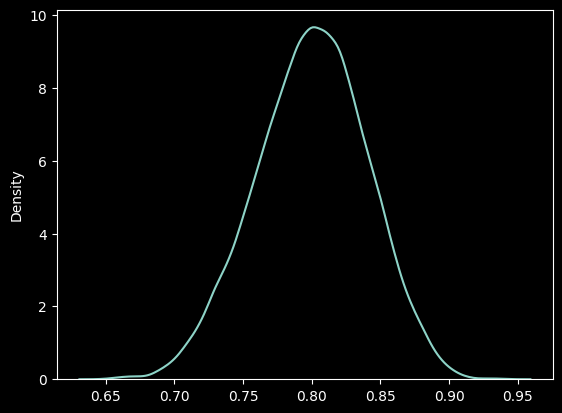

In [83]:
import seaborn as sns
sns.kdeplot([np.random.binomial(1,0.8, size=100).mean() for _ in range(10000)])

# Пример №2 Интернет магазин виноградного дня

Новый лендинг - Только белый виноградный день\
Лендинг - страничка на сайте \
Конверсия на текущем лендинге составляет 10% \
Придумали новый лендинг(добавили красный виноградный день) \
Протестим новый лендинг только 30% клиентам\
Пусть всего трафика - 1000 users \
Со старым лендингом - 70 продаж \
С новым - 48


In [84]:
df=pd.DataFrame({'group':['old landing (A)', 'new landing (B)'],
                 'lead':[700,300],
                 'sale':[70 ,48]})

In [85]:
df

,group,lead,sale
0,old landing (A),700,70
1,new landing (B),300,48


**посчитаем конверсию** \
convertial rate (CR)

In [86]:
df['conversion']=df['sale'] / df["lead"]
df

,group,lead,sale,conversion
0,old landing (A),700,70,0.10
1,new landing (B),300,48,0.16


Нужно протестировать гипотезы\
H0 - разницы нет \
Н1 - разница есть \
Пусть Н0 - верна \
какая вероятность получить такие же и более различия при том \
,что никакой разницы нет?



РЕШЕНИЕ:\
избавимся от групп(все смешаем)
(70+48) / 1000

In [87]:
(70+48)/1000

0.118

теперь уже можем генерировать выборки

In [88]:
np.random.binomial(1, 0.118, size=700).mean()

0.11714285714285715

In [89]:
np.random.binomial(1, 0.118, size=300).mean()

0.11

Необходимо делать двусторонние тесты т.к новый лендинг может и ухудшить

смотрим разность эксперимента

In [90]:
abs(0.1-0.16)

0.06

In [91]:
abs(np.random.binomial(1, 0.118, size=300).mean()
- np.random.binomial(1, 0.118, size=700).mean()) >= 0.06

False

In [92]:
[abs(np.random.binomial(1, 0.118, size=300).mean()
- np.random.binomial(1, 0.118, size=700).mean()) >= 0.06 for _ in range(10)]

[False, False, False, False, False, False, False, False, False, False]

In [93]:
np.mean([abs(np.random.binomial(1, 0.118, size=300).mean()
- np.random.binomial(1, 0.118, size=700).mean()) >= 0.06 for _ in range(10000)])

0.0087

получили p-value<<0.05 значит можем отвергнуть H0 т.к разница есть

In [94]:
proportions_ztest([70,48],[700,300])

(-2.695166510284625, 0.007035346384355496)

# ПОРОГ - УРОВЕНЬ ЗНАЧИМОСТИ (alpha)

альфа чаще всего = 0.05 \
выбираем ее до прохождения теста\
она сильно зависит от бизнес задачи\
альфа - вероятность отвергнуть верную нулевую гипотезу\
т.е альфа - вероятность ошибки 1 рода

Для двух близких и похожих выборок p-value\
распределен равномерно т.е\
для похожих выборок тест стабильно\
отвергает 5% верных решений (используется как A/A тест)

# Мощность - ОШИБКА 2 рода

Помечаем больного - как здорового\
мощность == recall \
также определяется до эксперимента


как получить размеры выборок для заданной мощности

In [95]:
import statsmodels.stats.api as sms
es=sms.proportion_effectsize(0.10, 0.15)
sms.NormalIndPower().solve_power(es, power=0.584, alpha=0.05, ratio=3/7)

# ratio - отношение между группами
# power

681.5816650531352

бутстрапим

In [98]:
from tqdm.notebook import tqdm

In [103]:
n=1000
res=[]
for _ in tqdm(range(n)):
  a=np.random.binomial(1, 0.10, size=680)
  b=np.random.binomial(1, 0.15, size=680)
  _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
  res.append(pval)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [104]:
(pd.Series(res)< 0.05).mean()

0.787